In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from source import layers, losses
from source.model import Model
from source.utils import batch_data, training_step, testing_step

In [2]:
full_data = pd.read_csv('data/2024_energy_efficiency_data.csv')

features_data = full_data.drop(['Heating Load', 'Cooling Load'], axis=1)
features_data = pd.get_dummies(features_data,
                           columns=['Orientation', 'Glazing Area Distribution'],
                           dtype=float)

full_data = pd.concat(
    [features_data, full_data['Heating Load']],
    axis=1,
)

full_data

,# Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Orientation_2.0,Orientation_3.0,Orientation_4.0,Orientation_5.0,Glazing Area Distribution_0.0,Glazing Area Distribution_1.0,Glazing Area Distribution_2.0,Glazing Area Distribution_3.0,Glazing Area Distribution_4.0,Glazing Area Distribution_5.0,Heating Load
0,0.98,514.5,294.0,110.25,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.55
1,0.98,514.5,294.0,110.25,7.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.55
2,0.98,514.5,294.0,110.25,7.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,15.55
3,0.90,563.5,318.5,122.50,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20.84
4,0.90,563.5,318.5,122.50,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.71,710.5,269.5,220.50,3.5,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.43
764,0.69,735.0,294.0,220.50,3.5,0.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.28
765,0.66,759.5,318.5,220.50,3.5,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.92
766,0.64,784.0,343.0,220.50,3.5,0.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.19


In [3]:
dataset = np.array(full_data)
np.random.default_rng().shuffle(dataset)

train_ratio = 0.75
train_size = int(len(dataset) * train_ratio)

X_train = dataset[:train_size, :-1]
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)
X_train = (X_train - train_mean) / train_std

X_test = (dataset[train_size:, :-1] - train_mean) / train_std

y_train = dataset[:train_size, -1:]
y_test = dataset[train_size:, -1:]

In [4]:
in_features = X_train.shape[1]
# print(in_features)
out_features = 16

model = Model([
    layers.Linear(in_features, out_features),
    layers.Sigmoid(),
    layers.Linear(out_features, 4),
    layers.Sigmoid(),
    layers.Linear(4, 1),
])

loss_fn = losses.MSE()

epochs = 10000
learning_rate = 0.01
batch_size = 32
train_losses = []
test_losses = []

In [5]:
for epoch in range(epochs):

    train_iter_losses, test_iter_losses = [], []
    for x, y in batch_data(X_train, y_train, batch_size):
        train_loss = training_step(x, y, model, loss_fn, learning_rate=0.01)
        train_iter_losses.append(train_loss * len(x))
    train_losses.append(np.sqrt(np.sum(train_iter_losses) / len(X_train)))

    for x, y in batch_data(X_test, y_test, batch_size):
        test_loss = testing_step(x, y, model, loss_fn)
        test_iter_losses.append(test_loss * len(x))
    test_losses.append(np.sqrt(np.sum(test_iter_losses) / len(X_test)))

    if (epoch + 1) % 1000 == 0:
        print(
            f'Epoch {epoch}: train loss {train_losses[-1]}, test loss {test_losses[-1]}'
        )

Epoch 999: train loss 0.4596967527890184, test loss 0.8816955761417368
Epoch 1999: train loss 0.36595854433229397, test loss 0.7681853063288939
Epoch 2999: train loss 0.33827618348305666, test loss 0.7244673702341853
Epoch 3999: train loss 0.3163776140968366, test loss 0.685603762066407
Epoch 4999: train loss 0.30380159447549865, test loss 0.664577451430583
Epoch 5999: train loss 0.2959867067926246, test loss 0.6587436538384596
Epoch 6999: train loss 0.2892562233016284, test loss 0.6652864878531367
Epoch 7999: train loss 0.28340491548868957, test loss 0.6798109446776149
Epoch 8999: train loss 0.2784323389263197, test loss 0.6950337623826016
Epoch 9999: train loss 0.2740561211253407, test loss 0.7077554959974127


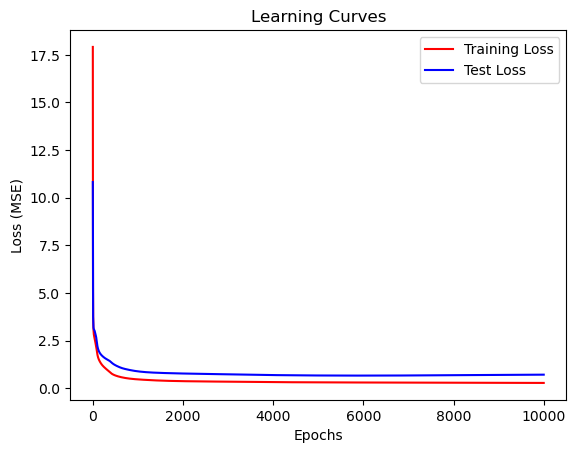

In [6]:
plt.plot(train_losses, label='Training Loss',  color='red')
plt.plot(test_losses, label='Test Loss',  color='blue')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

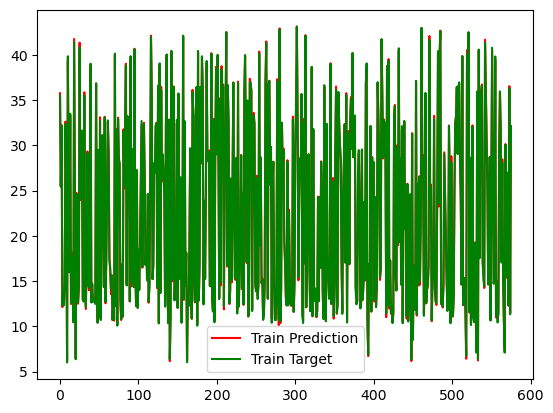

In [7]:
plt.plot(model(X_train), label='Train Prediction', color='red')
plt.plot(y_train, label='Train Target', color='green')
plt.legend()
plt.show()

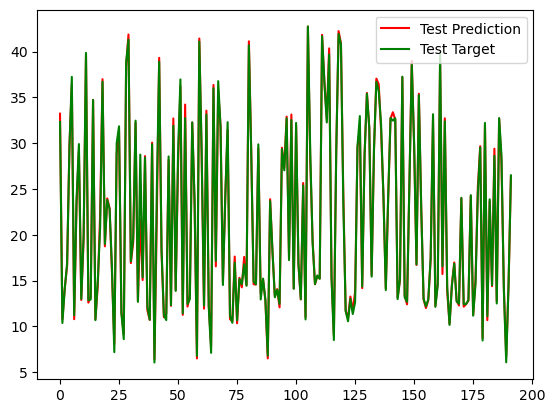

In [8]:
plt.plot(model(X_test), label='Test Prediction', color='red')
plt.plot(y_test, label='Test Target', color='green')
plt.legend()
plt.show()

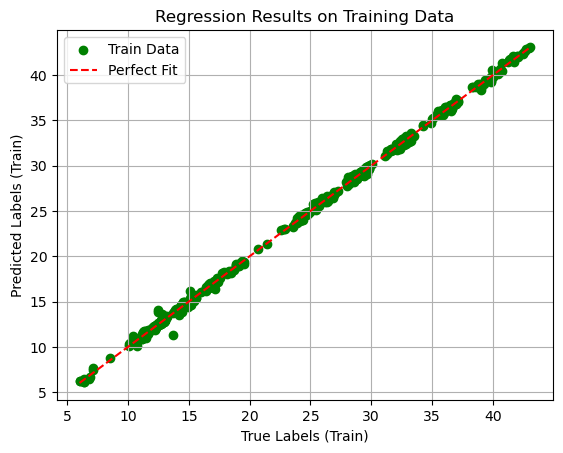

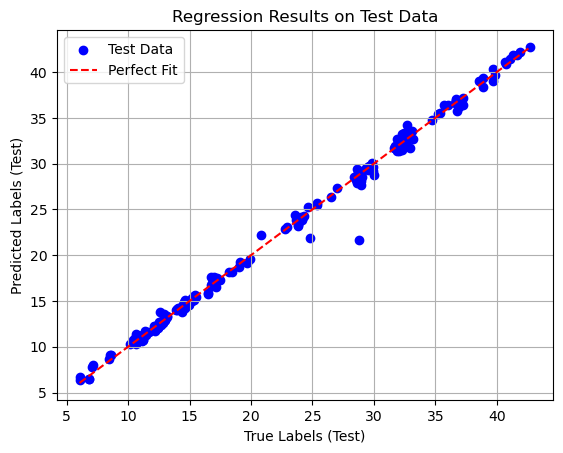

In [9]:
train_predictions = model(X_train)
test_predictions = model(X_test)

plt.scatter(y_train, train_predictions, color='green', label='Train Data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', label='Perfect Fit', linestyle='--')
plt.title('Regression Results on Training Data')
plt.xlabel('True Labels (Train)')
plt.ylabel('Predicted Labels (Train)')
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(y_test, test_predictions, color='blue', label='Test Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit', linestyle='--')
plt.title('Regression Results on Test Data')
plt.xlabel('True Labels (Test)')
plt.ylabel('Predicted Labels (Test)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def remain_features(feature, i):
    single_feat = np.zeros_like(feature)
    single_feat[:, i] = feature[:, i]
    return single_feat

In [11]:
features_i = {
    'Relative Compactness': [0],
    'Surface Area': [1],
    'Wall Area': [2],
    'Roof Area': [3],
    'Overall Height': [4],
    'Glazing Area': [5],
    'Orientation': [6, 7, 8, 9],
    'Glazing Area Distribution': [10, 11, 12, 13, 14, 15],
}

In [12]:
features_rms = {}

for feature_name, i in features_i.items():
    feature = remain_features(X_train, i)
    features_rms[feature_name] = np.sqrt(
        testing_step(feature, y_train, model, loss_fn))

feature_importance = [
    feat_name
    for feat_name, rms in sorted(features_rms.items(), key=lambda x: x[1])
]
print(f'Feature importance: {" is more important than ".join(feature_importance)}')

Feature importance: Overall Height is more important than Roof Area is more important than Relative Compactness is more important than Glazing Area is more important than Surface Area is more important than Orientation is more important than Glazing Area Distribution is more important than Wall Area
